#Interactive Proteus parallel example

##Load IPython support for working with MPI tasks

In [1]:
from IPython.parallel import Client
c = Client(profile="mpi")
view = c[:]
%load_ext parallelmagic
view.activate()

##Load interactive Proteus module, physics, and numerics on the MPI tasks and solve problem

In [2]:
%%px --block
from proteus.iproteus import * 
from proteus import default_n,default_s,default_so
import sw_2d_p,sw_2d_n
from proteus import Comm
comm = Comm.get()
nSteps = 101
sw_2d_n.tnList = [i*sw_2d_p.T/float(nSteps-1) for i in range(nSteps)]
pList = [sw_2d_p]
nList = [sw_2d_n]
so = default_so
so.name = pList[0].name = "sw_2d"
so.sList=[default_s]
so.tnList = sw_2d_n.tnList
nList[0].multilevelLinearSolver=default_n.KSP_petsc4py
#opts.viewer='vtk'
#viewers = Viewers.viewerOn(so.name+`comm.rank()`,opts.viewer)
from petsc4py import PETSc
OptDB = PETSc.Options()
OptDB.setValue("ksp_type","bcgsl")
OptDB.setValue("pc_type","asm")
OptDB.setValue("pc_asm_type","basic")
OptDB.setValue("sub_pc_type","jacobi")
OptDB.setValue("ksp_rtol",0.0)
OptDB.setValue("ksp_atol",1.0e-8)
ns = NumericalSolution.NS_base(so,pList,nList,so.sList,opts)
ns.calculateSolution('run1')
x = ns.modelList[0].levelModelList[-1].mesh.nodeArray[:,0]
y = ns.modelList[0].levelModelList[-1].mesh.nodeArray[:,1]
triangles = ns.modelList[0].levelModelList[-1].mesh.elementNodesArray
u = ns.modelList[0].levelModelList[-1].u[0].dof
#if comm.isMaster():
#    imageList = [window.png for window in viewers.windowDict.values()]
#else:
#    imageList = []

[stdout:0] 
TriangleBaseMesh nbase=1 baseFlags= pAq30Dena0.000800 
2  nSpace_global
[stdout:1] 
TriangleBaseMesh nbase=1 baseFlags= pAq30Dena0.000800 
2  nSpace_global
[stdout:2] 
TriangleBaseMesh nbase=1 baseFlags= pAq30Dena0.000800 
2  nSpace_global
[stdout:3] 
TriangleBaseMesh nbase=1 baseFlags= pAq30Dena0.000800 
2  nSpace_global


##Combine subdomain solutions and plot

Populating the interactive namespace from numpy and matplotlib


<matplotlib.tri.tricontour.TriContourSet instance at 0x7f4a01a16f80>

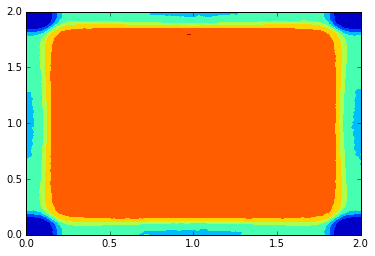

In [4]:
%pylab  inline
x = numpy.concatenate(view['x'])
y = numpy.concatenate(view['y'])
u = numpy.concatenate(view['u'])
n0=0
n1=n0+len(view['x'][0])
n2=n1+len(view['x'][1])
n3=n2+len(view['x'][2])
triangles = numpy.concatenate((view['triangles'][0]+n0,
                               view['triangles'][1]+n1,
                               view['triangles'][2]+n2,
                               view['triangles'][3]+n3))
tricontourf(x,y,triangles,u)